<a href="https://colab.research.google.com/github/pmdino/CS39AA-Project/blob/main/CS39AA_Project_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir mydata
!cp -r /content/drive/MyDrive/data/trainnews.csv /content/mydata

In [2]:
! pip install transformers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel 
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from transformers import AutoTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 26.2 MB/s 
     |████████████████████████████████| 182 kB 7.5 MB/s 
     |████████████████████████████████| 7.6 MB 17.1 MB/s 


In [3]:
news_data = pd.read_csv("./mydata/trainnews.csv")
news_data.head()
news_data = news_data.fillna('')

news_data['content'] = news_data['author'] + news_data['text'] + news_data['title']
X = news_data['content'].copy()
y = news_data['label'].copy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)


In [4]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [5]:
def tokenize(X):
    
    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [6]:
X_train_token = tokenize(X_train)
X_val_token = tokenize(X_val)

In [7]:
maxlen=100
def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(maxlen,),dtype=tf.int32)
    input_mask=Input(shape=(maxlen,),dtype=tf.int32)
    bert_layer=bert_model([input_ids,input_mask])[1]
    x=Dropout(0.5)(bert_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model

In [8]:
model=create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [9]:
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

In [11]:
history = model.fit(x = {'input_1':X_train_token['input_ids'],'input_2':X_train_token['attention_mask']}, y = y_train, epochs=15, validation_split = 0.2, batch_size = 30, callbacks=[callback])

Epoch 1/15
444/444 [==============================] - 348s 740ms/step - loss: 0.2539 - accuracy: 0.8896 - val_loss: 0.1253 - val_accuracy: 0.9603
Epoch 2/15
444/444 [==============================] - 326s 735ms/step - loss: 0.1001 - accuracy: 0.9672 - val_loss: 0.0907 - val_accuracy: 0.9706
Epoch 3/15
444/444 [==============================] - 326s 734ms/step - loss: 0.0769 - accuracy: 0.9758 - val_loss: 0.0876 - val_accuracy: 0.9730
Epoch 4/15
444/444 [==============================] - 326s 734ms/step - loss: 0.0659 - accuracy: 0.9794 - val_loss: 0.0787 - val_accuracy: 0.9745
Epoch 5/15
444/444 [==============================] - 325s 733ms/step - loss: 0.0556 - accuracy: 0.9830 - val_loss: 0.0683 - val_accuracy: 0.9775
Epoch 6/15
444/444 [==============================] - 326s 734ms/step - loss: 0.0496 - accuracy: 0.9854 - val_loss: 0.0749 - val_accuracy: 0.9769
Epoch 7/15
444/444 [==============================] - 325s 733ms/step - loss: 0.0469 - accuracy: 0.9862 - val_loss: 0.0689 -

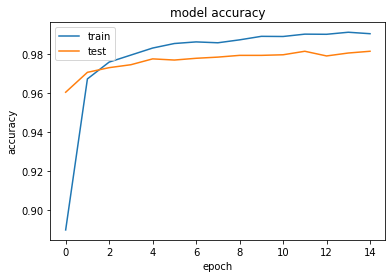

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

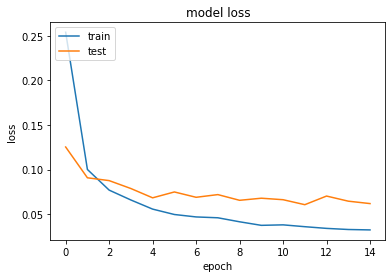

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
y_pred_train = np.where(model.predict({ 'input_1' : X_train_token['input_ids'] , 'input_2' : X_train_token['attention_mask']}) >=0.5,1,0)
y_pred_val = np.where(model.predict({ 'input_1' : X_val_token['input_ids'] , 'input_2' : X_val_token['attention_mask']}) >=0.5,1,0)

130/130 [==============================] - 29s 224ms/step


accuracy (on X_train): 0.9922
accuracy (on X_val): 0.9793


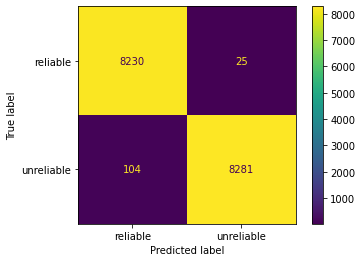

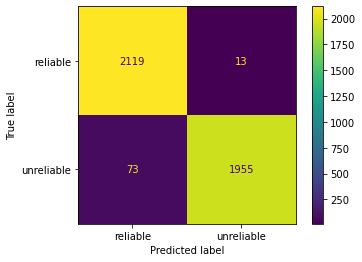

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
disp = ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train), display_labels=['reliable', 'unreliable'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(y_train, y_pred_train):.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred_val), display_labels=['reliable', 'unreliable'])
disp.plot()
print(f"accuracy (on X_val): {accuracy_score(y_val, y_pred_val):.4f}")

In [16]:
from transformers import RobertaTokenizer, TFRobertaModel

In [17]:
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [18]:
def tokenizeR(X):
    
    X = roberta_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [19]:
X_train_tokenR = tokenizeR(X_train)
X_val_tokenR = tokenizeR(X_val)

In [20]:
maxlen=100
def create_modelR():
    dropout_rate=0.2
    input_ids=Input(shape=(maxlen,),dtype=tf.int32)
    input_mask=Input(shape=(maxlen,),dtype=tf.int32)
    roberta_layer=roberta_model([input_ids,input_mask])[1]
    x=Dropout(0.5)(roberta_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model

In [21]:
modelR=create_modelR()
modelR.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_3[0][0]',                
 el)                            thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                         

In [22]:
modelR.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

In [23]:
tf.config.run_functions_eagerly(True)

In [24]:
historyR = modelR.fit(x = {'input_3':X_train_tokenR['input_ids'],'input_4':X_train_tokenR['attention_mask']}, y = y_train, epochs=10, validation_split = 0.2, batch_size = 30, callbacks=[callback])

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


444/444 [==============================] - 427s 960ms/step - loss: 0.6704 - accuracy: 0.5829 - val_loss: 0.4958 - val_accuracy: 0.9105
Epoch 2/10
444/444 [==============================] - 402s 905ms/step - loss: 0.4438 - accuracy: 0.8171 - val_loss: 0.2548 - val_accuracy: 0.9522
Epoch 3/10
444/444 [==============================] - 402s 904ms/step - loss: 0.2251 - accuracy: 0.9283 - val_loss: 0.1064 - val_accuracy: 0.9763
Epoch 4/10
444/444 [==============================] - 417s 939ms/step - loss: 0.1268 - accuracy: 0.9591 - val_loss: 0.0716 - val_accuracy: 0.9796
Epoch 5/10
444/444 [==============================] - 401s 904ms/step - loss: 0.0934 - accuracy: 0.9699 - val_loss: 0.0614 - val_accuracy: 0.9817
Epoch 6/10
444/444 [==============================] - 419s 943ms/step - loss: 0.0808 - accuracy: 0.9738 - val_loss: 0.0556 - val_accuracy: 0.9823
Epoch 7/10
444/444 [==============================] - 397s 893ms/step - loss: 0.0667 - accuracy: 0.9784 - val_loss: 0.0471 - val_accura

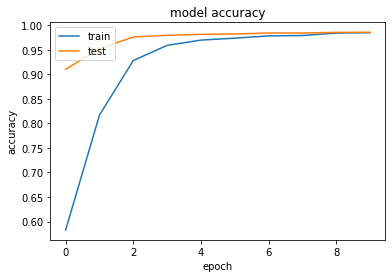

In [25]:
plt.plot(historyR.history['accuracy'])
plt.plot(historyR.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

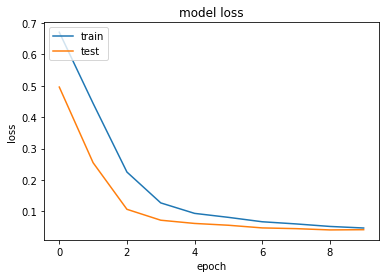

In [26]:
plt.plot(historyR.history['loss'])
plt.plot(historyR.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
y_pred_train = np.where(modelR.predict({ 'input_3' : X_train_tokenR['input_ids'] , 'input_4' : X_train_tokenR['attention_mask']}) >=0.5,1,0)
y_pred_val = np.where(modelR.predict({ 'input_3' : X_val_tokenR['input_ids'] , 'input_4' : X_val_tokenR['attention_mask']}) >=0.5,1,0)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


130/130 [==============================] - 30s 229ms/step


accuracy (on X_train): 0.9876
accuracy (on X_val): 0.9882


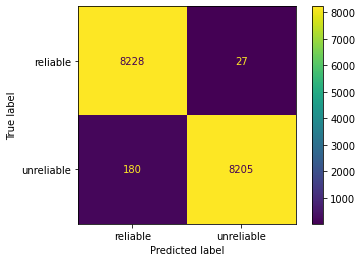

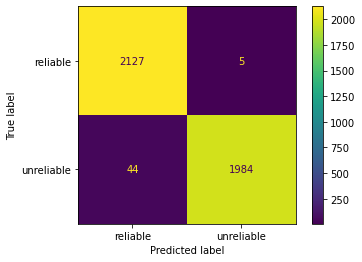

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
disp = ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train), display_labels=['reliable', 'unreliable'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(y_train, y_pred_train):.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred_val), display_labels=['reliable', 'unreliable'])
disp.plot()
print(f"accuracy (on X_val): {accuracy_score(y_val, y_pred_val):.4f}")